# Nuclei segmentation

More details in:

https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html

https://github.com/broadinstitute/Tangram/blob/master/tangram_tutorial.ipynb

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

print(f"tangram=={tg.__version__}")

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.1
tangram==0.4.0


We will load the public data available in Squidpy.

In [2]:
adata_st = sc.read_h5ad('../data/st_visp4.h5ad')

In [3]:
adata_st

AnnData object with n_obs × n_vars = 300 × 4258
    obs: 'in_tissue', 'array_row', 'array_col', 'mouse', 'library_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'library_id_colors', 'mouse_colors', 'neighbors', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'Scanorama', 'X_pca', 'X_scanorama', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [4]:
# Revert back to raw matrix to have all genes
adata_st = adata_st.raw.to_adata()


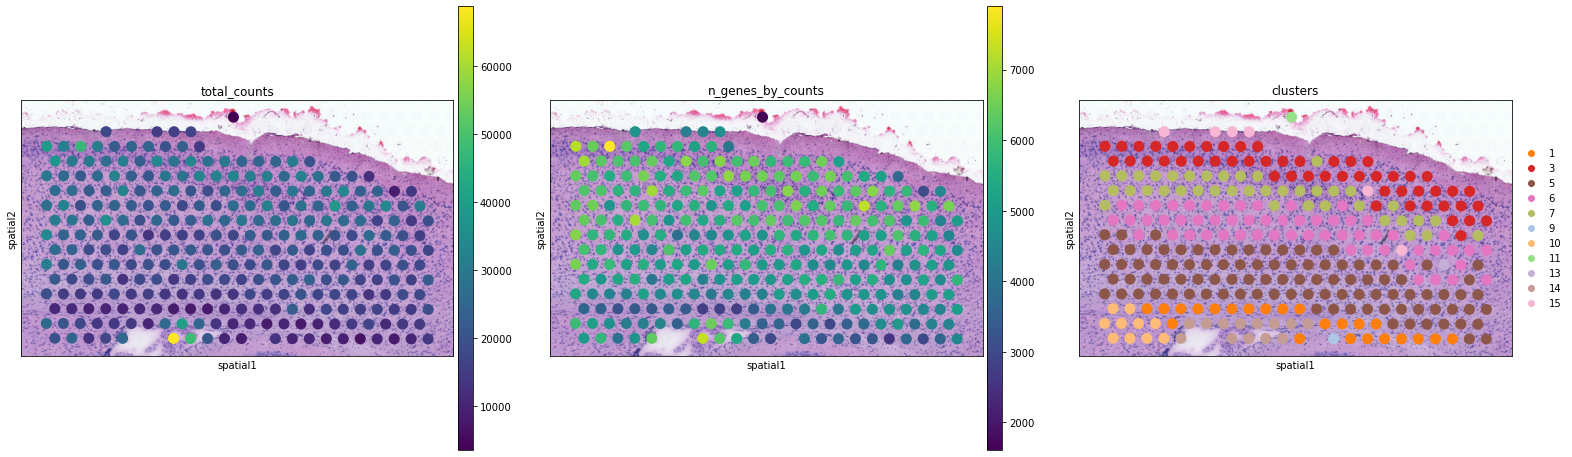

In [5]:
sample = 'ST8059051'

plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata_st, img_key="hires", color=["total_counts", "n_genes_by_counts","clusters"], library_id = sample)



## Create the image container

In [6]:
# check scalefactors
sf = adata_st.uns["spatial"][sample]["scalefactors"]["tissue_hires_scalef"]
sf

0.11640766

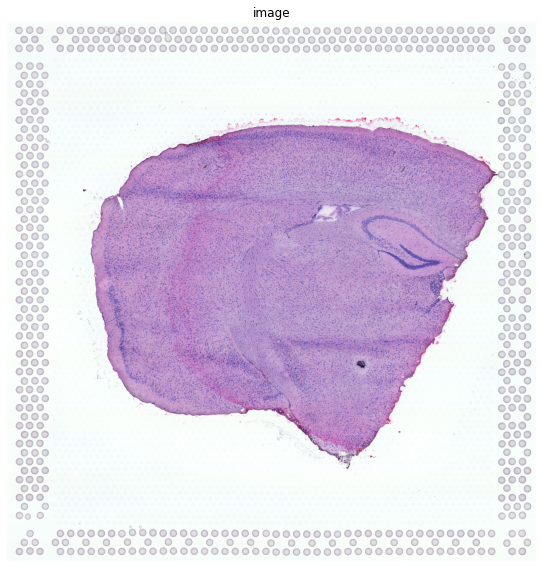

In [7]:
img = sq.im.ImageContainer(adata_st.uns['spatial'][sample]['images']['hires'], scale = sf)

#img = sq.im.ImageContainer(img,
#                           dims=("channels", "y", "x"),
#                           layer="img1",
#                           scale = sf,
#                           library_id = sample,
#                          )

img.show()

In [8]:
# load sc data

adata_sc = sc.read_h5ad('../data/sc_visp_subsampled200.h5ad')

In [9]:
adata_sc

AnnData object with n_obs × n_vars = 3714 × 1500
    obs: 'title', 'source_name', 'organism', 'donor_id', 'donor_sex', 'donor_genotype', 'injection_type', 'injection_target', 'injected_material', 'dissected_region', 'dissected_layer', 'facs_gating', 'facs_date', 'rna_amplification_set', 'sequencing_tube', 'sequencing_batch', 'sequencing_qc_pass_fail', 'cell_class', 'cell_subclass', 'cell_cluster', 'molecule', 'SRA_Run', 'GEO_Sample', 'GEO_Sample_Title', 'clusters', 'batch'
    var: 'gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_class_colors', 'cell_cluster_colors', 'cell_subclass_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'

In [10]:
# revert back to raw
adata_sc = adata_sc.raw.to_adata()

In [11]:
adata_sc.obs['cell_subclass'].value_counts()

Vip           200
Lamp5         200
L2/3 IT       200
L4            200
L5 IT         200
L5 PT         200
L6 CT         200
L6 IT         200
L6b           200
Astro         200
NP            200
Pvalb         200
Sncg          200
Sst           200
Oligo         186
Endo          166
VLMC          133
Macrophage    131
SMC           109
Serpinf1       85
Meis2          55
Peri           32
CR             17
Name: cell_subclass, dtype: int64

## For plotting we need:
- the number of unique segmentation objects (i.e. nuclei) under each spot.
- the coordinates of the centroids of the segmentation object.


Skip nuclei segmentation, and run without information on cell numbers.

We can visualize the total number of objects under each spot with scanpy.

## Deconvolution and mapping
At this stage, we have all we need for the deconvolution task. 
First, we need to find a set of common genes the single cell and spatial datasets. 
We will use the top 100 DEGs per single cell cluster. Other common gene sets are variable genes in SC data, intersection of the highly variable genes from both datasets.

In [12]:
adata_sc

AnnData object with n_obs × n_vars = 3714 × 45768
    obs: 'title', 'source_name', 'organism', 'donor_id', 'donor_sex', 'donor_genotype', 'injection_type', 'injection_target', 'injected_material', 'dissected_region', 'dissected_layer', 'facs_gating', 'facs_date', 'rna_amplification_set', 'sequencing_tube', 'sequencing_batch', 'sequencing_qc_pass_fail', 'cell_class', 'cell_subclass', 'cell_cluster', 'molecule', 'SRA_Run', 'GEO_Sample', 'GEO_Sample_Title', 'clusters', 'batch'
    uns: 'cell_class_colors', 'cell_cluster_colors', 'cell_subclass_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'

In [13]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass")

In [14]:
# Make df with top 100 genes per cluster

markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
genes_sc = np.unique(markers_df.melt().value.values)
genes_st = adata_st.var_names.values
genes = list(set(genes_sc).intersection(set(genes_st)))
print(len(genes))

gene_file = "../data/tangram_genes.txt"
with open(gene_file, 'w') as filehandle:
    for x in genes:
        filehandle.write('%s\n' % x)

1270


# Nuclei segmentation

For segmentation of H&E images, following more or less this tutorial:file:///Users/asbj/projects/Giacomello/s_giacomello_2005/source/brain/deconv/tangram/brain_segment_hne.html

However should be better to have the fullres image.

Need to crop image to same region

In [15]:
img

ImageContainer[shape=(2000, 1963), layers=['image']]

In [16]:
sf

0.11640766

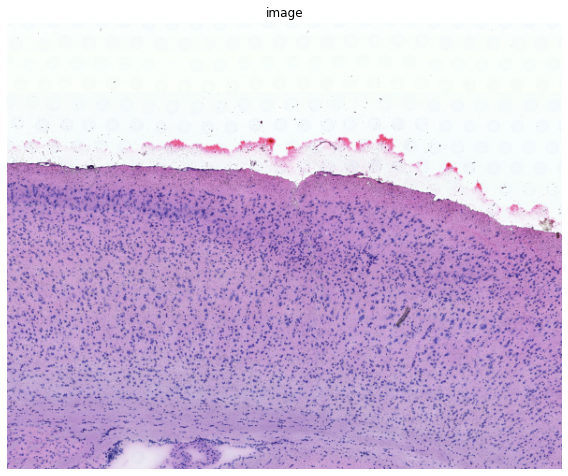

In [17]:
#crop1 = img.crop_corner(6000*sf, 0, size=(5000 * sf, 5000*sf), scale=1)
crop = img.crop_corner( int(2000 * sf), int(9000 * sf), size=( int(4100*sf), int(5100*sf)), scale=1)
crop.show(layer="image")



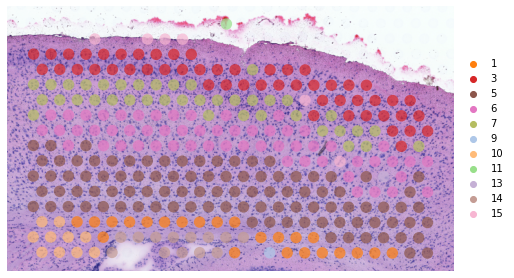

In [18]:
sc.pl.spatial(
    adata_st, color="clusters", library_id = sample, alpha=0.7, frameon=False,
    title=""
)

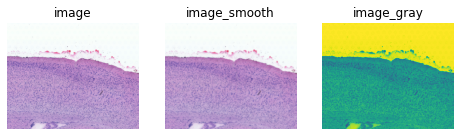

In [19]:
# smooth image
sq.im.process(crop, layer="image", method="smooth")
sq.im.process(crop, layer="image", method="gray")
#sq.im.process(crop, layer="image", method="smooth", sigma=4)

# plot the result
fig, axes = plt.subplots(1, 3)
for layer, ax in zip(["image", "image_smooth", "image_gray"], axes):
    crop.show(layer, ax=ax)
    ax.set_title(layer)
    
    

In [20]:
crop

ImageContainer[shape=(477, 593), layers=['image', 'image_gray', 'image_smooth']]

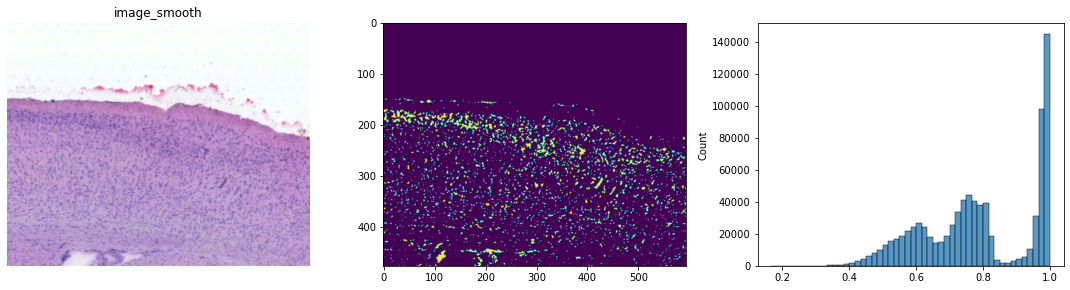

In [21]:
import seaborn as sns


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
crop.show("image_smooth", cmap="gray", ax=axes[0])
axes[1].imshow(crop["image_smooth"][:, :, 0, 0] < 0.6)
_ = sns.histplot(np.array(crop["image_smooth"]).flatten(), bins=50, ax=axes[2])
plt.tight_layout()


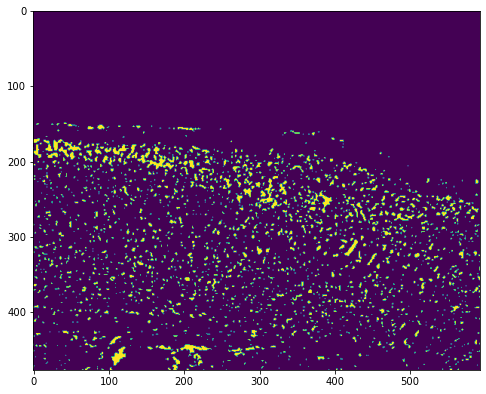

In [22]:
plt.imshow(crop["image_smooth"][:, :, 0, 0] < 0.6)

Judging from the histogram in the third plot we decide on a cutoff for the intensities (in this example 0.6) and in the middle image, all pixels above that level are shown.

In [23]:
sq.im.segment(crop, layer="image_smooth", method="watershed", thresh=0.6, geq=False)



In [24]:
crop

ImageContainer[shape=(477, 593), layers=['image', 'image_gray', 'image_smooth', 'segmented_watershed']]

ImageContainer[shape=(477, 593), layers=['image', 'image_gray', 'image_smooth', 'segmented_watershed']]
Number of segments in crop: 2395


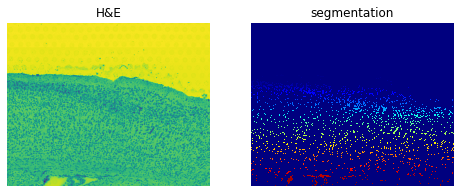

In [25]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_watershed']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_watershed", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

In [26]:
# in tutorial with DAPI stain

# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    crop,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
    library_id = sample
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 30.86/s]


In [27]:
adata_st.obsm["image_features"]["segmentation_label"].value_counts()

4     70
2     54
3     50
5     41
1     40
6     20
0      8
7      7
9      5
8      4
10     1
Name: segmentation_label, dtype: int64

In [28]:
adata_st.obsm['image_features']

,segmentation_label,segmentation_centroid
AAACAGAGCGACTCCT-1-ST8059051,5,"[[1372.0, 452.93333333333334], [1374.947976878..."
AAACTCGTGATATAAG-1-ST8059051,2,"[[1613.0, nan], [1630.0, nan]]"
AAATAACCATACGGGA-1-ST8059051,6,"[[1297.4055118110236, 448.52830188679246], [12..."
AAATGATTCGATCAGC-1-ST8059051,3,"[[1588.0, 600.0], [1589.888888888889, 617.0], ..."
AAATGGCATGTCTTGT-1-ST8059051,4,"[[1055.0, 423.0], [1055.1642512077294, 440.0],..."
...,...,...
TTGATGTGTAGTCCCG-1-ST8059051,4,"[[1321.0, 676.7483870967742], [1330.1467391304..."
TTGCGTGAACGCTTAG-1-ST8059051,5,"[[1397.0, 448.87719298245617], [1404.892857142..."
TTGCTCCCATACCGGA-1-ST8059051,4,"[[1092.0, 629.9047619047619], [1095.1097560975..."
TTGGCCTAGAATTTCG-1-ST8059051,3,"[[1220.0, 489.0], [1233.019512195122, 490.4782..."


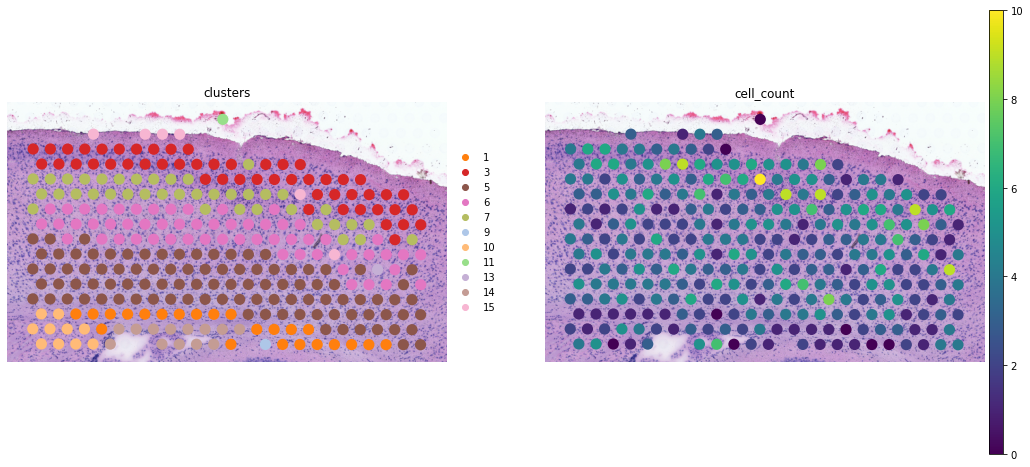

In [29]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["clusters", "cell_count"], frameon=False, library_id = sample)

Predicted number of cells vs counts/genes

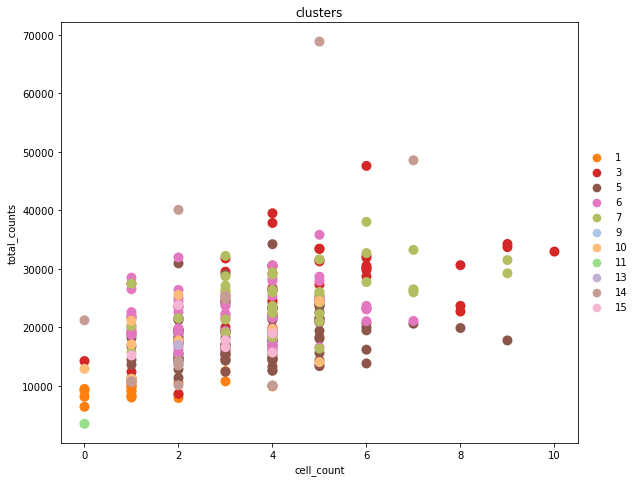

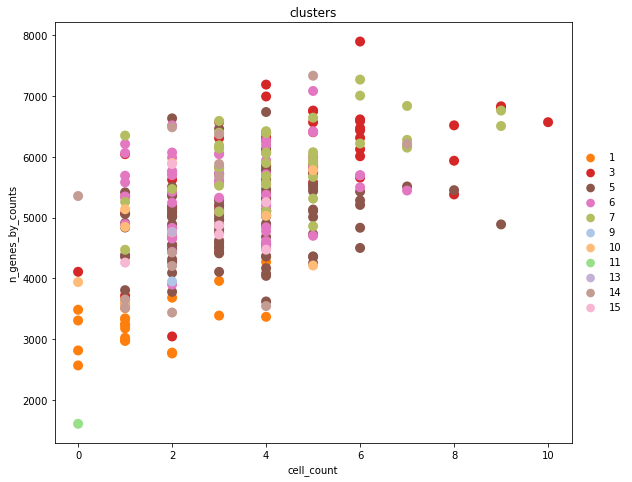

In [30]:
sc.pl.scatter(adata_st, "cell_count", "total_counts", color = "clusters")
sc.pl.scatter(adata_st, "cell_count", "n_genes_by_counts", color = "clusters")

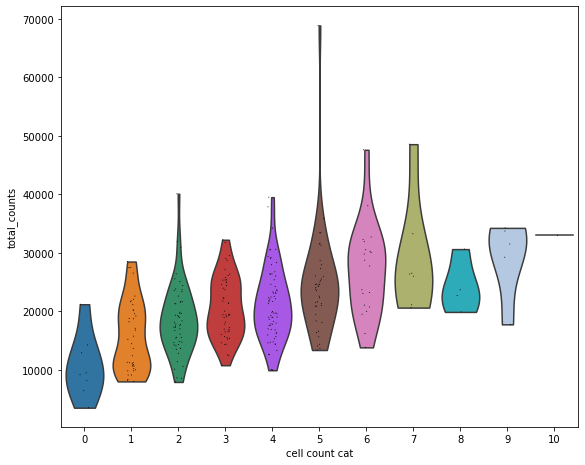

In [31]:
# violins can only be done with categorical values, not numeric.

adata_st.obs["cell_count_cat"] = adata_st.obs["cell_count"].astype("category")

sc.pl.violin(adata_st,"total_counts", "cell_count_cat")


## Run Tangram 

In [32]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1247 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:15965 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [ ]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1247 genes and customized density_prior in constrained mode...


Score: 0.666, KL reg: 0.161, Count reg: 818.890, Lambda f reg: 768.616
Score: 0.717, KL reg: 0.015, Count reg: 0.419, Lambda f reg: 121.087
Score: 0.719, KL reg: 0.015, Count reg: 0.010, Lambda f reg: 36.143
Score: 0.719, KL reg: 0.015, Count reg: 0.030, Lambda f reg: 24.940
Score: 0.719, KL reg: 0.015, Count reg: 0.043, Lambda f reg: 21.111
Score: 0.719, KL reg: 0.015, Count reg: 0.254, Lambda f reg: 18.193
Score: 0.719, KL reg: 0.015, Count reg: 0.361, Lambda f reg: 16.581
Score: 0.719, KL reg: 0.015, Count reg: 0.049, Lambda f reg: 15.276


In [ ]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")


In [ ]:
adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)


In [ ]:
adata_st.obsm["tangram_ct_pred"]["Astro"]

sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=["Astro"],
)

In [ ]:
sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
)

In [ ]:
adata_st.obs.columns

In [ ]:
tg.create_segment_cell_df(adata_st)

In [ ]:
adata_st.uns["tangram_cell_segmentation"].head()


In [ ]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)

In [ ]:
adata_st.obsm["tangram_ct_count"].head()

In [ ]:
adata_segment = tg.deconvolve_cell_annotations(adata_st)


In [ ]:
adata_segment.obs.head()


In [ ]:
adata_segment

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment,
    color="cluster",
    library_id = sample,
    size=0.05,
    show=False,
    frameon=False,
    alpha_img=0.2,
    legend_fontsize=20,
#    scale_factor = sf,
    ax=ax,
)

OBS! Need to check why the image does not plot properly!

## Image features

In [ ]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata_st,
        crop.compute(),
        features="summary",
        layer = "image",
        library_id = sample,
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata_st.obsm["features"] = pd.concat(
    [adata_st.obsm[f] for f in adata_st.obsm.keys() if "features_summary" in f], axis="columns"
)


In [ ]:
# make sure that we have no duplicated feature names in the combined table
import anndata as ad

adata_st.obsm["features"].columns = ad.utils.make_index_unique(adata_st.obsm["features"].columns)

In [ ]:
# cluster

# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata_st.obs["features_cluster"] = cluster_features(adata_st.obsm["features"], like="summary")

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata_st, color=["features_cluster", "clusters"], library_id = sample)

In [ ]:
sq.gr.spatial_neighbors(adata_st)
sq.gr.nhood_enrichment(adata_st, cluster_key="clusters")
sq.pl.nhood_enrichment(adata_st, cluster_key="clusters")

In [ ]:
# calculate co-occurence to cluster 3

sq.gr.co_occurrence(adata_st, cluster_key="clusters")
sq.pl.co_occurrence(
    adata_st,
    cluster_key="clusters",
    clusters="3",
    figsize=(8, 4),
)

In [ ]:
sc.pl.spatial(adata_st, color=["clusters"], library_id = sample)